In [ ]:
import os
import sys

# Go up one directory level to reach root
root_dir = os.path.dirname(os.getcwd())
os.chdir(root_dir)

# Add root to Python path
sys.path.insert(0, root_dir)

console_log(f"Current working directory: {os.getcwd()}")
console_log(f"Root directory added to path: {root_dir}")

In [ ]:
%load_ext autoreload
%autoreload 2
from functions._utils_ import *

In [ ]:
# hirushu_dir = os.getcwd() + '/test_rawdata/Tamura/引き継ぎ/ヒルシュ'
# hirushu_dir

# raman_raw_dir = hirushu_dir + '/raman_raw'
# hirsch_dir = {}
# normal_dir = {}
# other_dir = {}
# for l in os.listdir(raman_raw_dir):
#     if "hirsch" in l:
#         hirsch_dir[l] = raman_raw_dir + '/' + l
#         continue

#     if "normal" in l:
#         normal_dir[l] = raman_raw_dir + '/' + l
#         continue

#     other_dir[l] = raman_raw_dir + '/' + l

In [ ]:
hirushu_dir = os.getcwd() + '/test_rawdata/Tamura/引き継ぎ/ヒルシュ'

hirsch_dfs = []
m = 1
n = 1
window_size = 50
tst_hirsch_df = []
tst_normal_df = []
for k in range(1, 4):
    for p in range(1, 4):
        csv_path = os.path.join(
            hirushu_dir, 'Raman_raw', f'hirsch{k}_noise{p}')
        loader = RamanDataLoader(csv_path)
        df = loader.data
        processor = RamanNoiseProcessor(df)
        processed_df = processor.baselineAndGaussianNoise(
            window_size=window_size)
        if k == m:
            tst_hirsch_df.append(processed_df)
        else:
            hirsch_dfs.append(processed_df)

normal_dfs = []
for k in range(1, 4):
    for p in range(1, 4):
        csv_path = os.path.join(
            hirushu_dir, 'Raman_raw', f'normal{k}_noise{p}')  # os.path.join(hirushu_dir, 'データ', 'merged_data_raw', f'Case{k}', 'normal', 'normal.csv')
        loader = RamanDataLoader(csv_path)
        df = loader.data
        processor = RamanNoiseProcessor(df)
        processed_df = processor.baselineAndGaussianNoise(
            window_size=window_size)
        if k == n:
            tst_normal_df.append(processed_df)
        else:
            normal_dfs.append(processed_df)

In [ ]:
labels = ["normal", "hirsch"]
region = (1000, 1800)  # Raman region of interest
# https://ramanspy.readthedocs.io/en/latest/preprocessing.html
# https://www.nature.com/articles/s41377-024-01394-5
# preprocess_steps_test = [
#         rp.preprocessing.misc.Cropper(region=region),
#         rp.preprocessing.despike.WhitakerHayes(),
#         MovingAverage(window_length=5),
#         rp.preprocessing.baseline.ModPoly(tol=0.01),
#         # rp.preprocessing.baseline.ASPLS(lam=1e5, tol=0.01),
#         rp.preprocessing.normalise.Vector(),
#         # SNV(),
#     ]

preprocess_steps_test = [
    rp.preprocessing.misc.Cropper(region=region),
    rp.preprocessing.despike.WhitakerHayes(),
    rp.preprocessing.denoise.SavGol(window_length=13, polyorder=3),
    rp.preprocessing.baseline.ASPLS(),
    # rp.preprocessing.baseline.ModPoly(tol=0.001),
    rp.preprocessing.normalise.Vector(),
    # SNV()
]

In [ ]:
train_hirsch = RamanPipeline().preprocess(
    dfs=hirsch_dfs,
    label=labels[1],
    region=region,
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=True
)

train_normal = RamanPipeline().preprocess(
    dfs=normal_dfs,
    label=labels[0],
    region=region,
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=False
)

In [ ]:
test_hirsch_df = RamanPipeline().preprocess(
    dfs=tst_hirsch_df,
    region=region,
    label=labels[1],
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=False
)

test_normal_df = RamanPipeline().preprocess(
    dfs=tst_normal_df,
    region=region,
    label=labels[0],
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=False
)

In [ ]:
ramanML = RamanML()
kernel = "linear"
MODEL_SHORT = "RF"  # f"SVC-{kernel.upper()}" #

if "SVC" in MODEL_SHORT:
    mlresult = ramanML.train_svc(disease_data=([train_hirsch["processed"]], labels[1]),
                                 normal_data=([train_normal["processed"]], labels[0]), param_search=True, test_size=0.2,
                                 SVC_model=ramanML.SVCMODEL(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced'))
else:
    mlresult = ramanML.train_rf(disease_data=([train_hirsch["processed"]], labels[1]),
                                normal_data=([train_normal["processed"]], labels[0]), param_search=False, test_size=0.3,
                                RF_model=ramanML.RFMODEL(n_estimators=200,           # More trees for stability
                                                         criterion="entropy",           # Or "entropy" for information gain
                                                         max_depth=10,
                                                         min_samples_split=5,
                                                         min_samples_leaf=5,
                                                         max_features="sqrt",        # Good default for classification
                                                         class_weight="balanced",    # Important for imbalanced classes
                                                         random_state=42,            # For reproducibility
                                                         n_jobs=-1,                  # Use all CPU cores
                                                         bootstrap=True,             # Default
                                                         oob_score=True,),)
console_log(f"training time: {round((mlresult['training_time']) / 60, 5)}")
console_log(mlresult["model"].get_params())

In [ ]:
pprint(translate_confusion_matrix(
    mlresult["confusion_matrix"], labels), indent=2)
pprint(mlresult["classification_report"], indent=2)
console_log(
    f"CV Accuracy: {mlresult['cross_val_score'].mean():.3f} ± {mlresult['cross_val_score'].std():.3f}")

In [ ]:
normal_spectra = [test_normal_df, ]
cancer_spectra = [test_hirsch_df, ]
test_spectra = [k["processed"] for k in normal_spectra + cancer_spectra]
true_labels = []
for k in cancer_spectra + normal_spectra:
    true_labels.extend(k["labels"])

Predicting all 310 samples
Predicting 310 test samples with 858 features.
Using threshold-based prediction with threshold=0.26 for positive class 'hirsch'
{np.str_('hirsch'): 0.5451612903225806, np.str_('normal'): 0.45483870967741935}
'y_true exist: 310'
{ 'false_hirsch': [ (180, 0.3850659855658772),
                    (181, 0.38101982581636745),
                    (183, 0.5329520244905946),
                    (187, 0.39669207499489995),
                    (188, 0.29005044328739543),
                    (189, 0.3892628255862752),
                    (190, 0.5989973283317296),
                    (191, 0.5758834016012192),
                    (192, 0.5695991643919456),
                    (202, 0.4708997568697298),
                    (204, 0.3623665561944664),
                    (205, 0.3169662358361245),
                    (209, 0.2833143924515878),
                    (212, 0.2660869909149508),
                    (214, 0.3056766853454138),
                    (216, 0.441441739

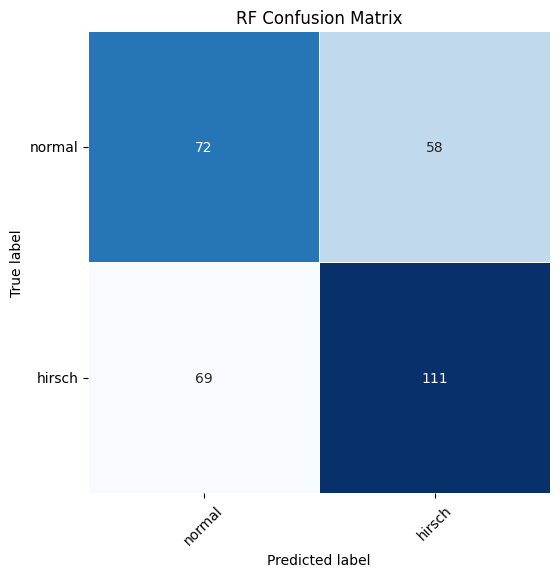

Predict Accuracy:
normal: 55.38%
hirsch: 61.67%


In [ ]:
sample_indices = None

if "SVC" in MODEL_SHORT:
    predict_data = ramanML.predict(
        test_spectra=test_spectra,
        true_labels=true_labels,
        # model = mlresult["model"]
        sample_indices=sample_indices,
    )
else:
    predict_data = ramanML.predict(
        test_spectra=test_spectra,
        positive_label=labels[1],
        true_labels=true_labels,
        # model = mlresult["model"],
        threshold=0.26,
        use_threshold=True,
    )

pprint(predict_data["label_percentages"], indent=2)
# pprint(predict_data["most_common_label"])
if 'y_true' in predict_data:
    pprint(f"y_true exist: {len(predict_data['y_true'])}")
    pprint(predict_data["prediction_breakdown"], indent=2)

visualizer = RamanVisualizer(ramanML=ramanML)
predict_accuracy, plotdata = visualizer.confusion_matrix_heatmap(
    y_true=predict_data["y_true"],          # true labels for test set
    y_pred=predict_data["y_pred"],  # predicted labels for test set
    # class names, e.g. ["benign", "cancer"]
    class_labels=labels,
    title=f"{MODEL_SHORT} Confusion Matrix",
    normalize=False,
    cmap="Blues",
    figsize=(8, 6),
    fmt="d",
)
console_log("Predict Accuracy:")
console_log("=====================================")
for i, (label, percentage) in enumerate(predict_accuracy.items()):
    console_log(f"{label}: {percentage:.2f}%")

Inspecting 4 spectra...

Analyzing spectrum 1/4...
Using stored test labels for all samples
Predicting all 1 samples
Predicting 1 test samples with 858 features.
Detected model: RandomForestClassifier, Linear SVC: False
Using stored data: 784 background samples, 1 test samples
Background data reduced to 30 samples
Computing SHAP values for 1 samples with 30 background samples...
Using TreeExplainer for RandomForest model...


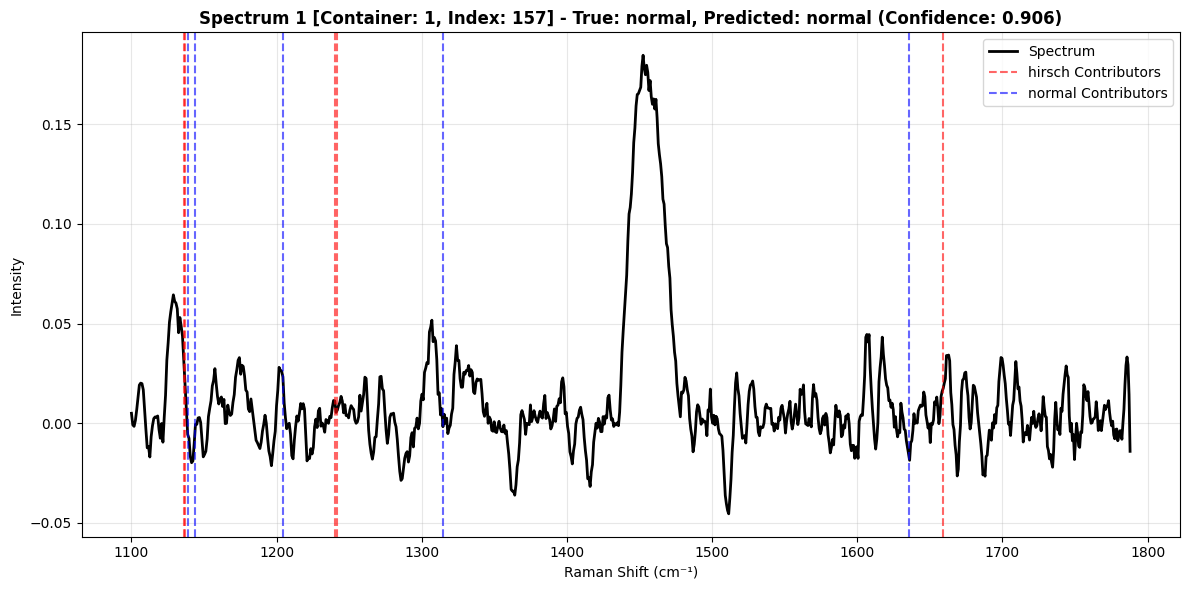

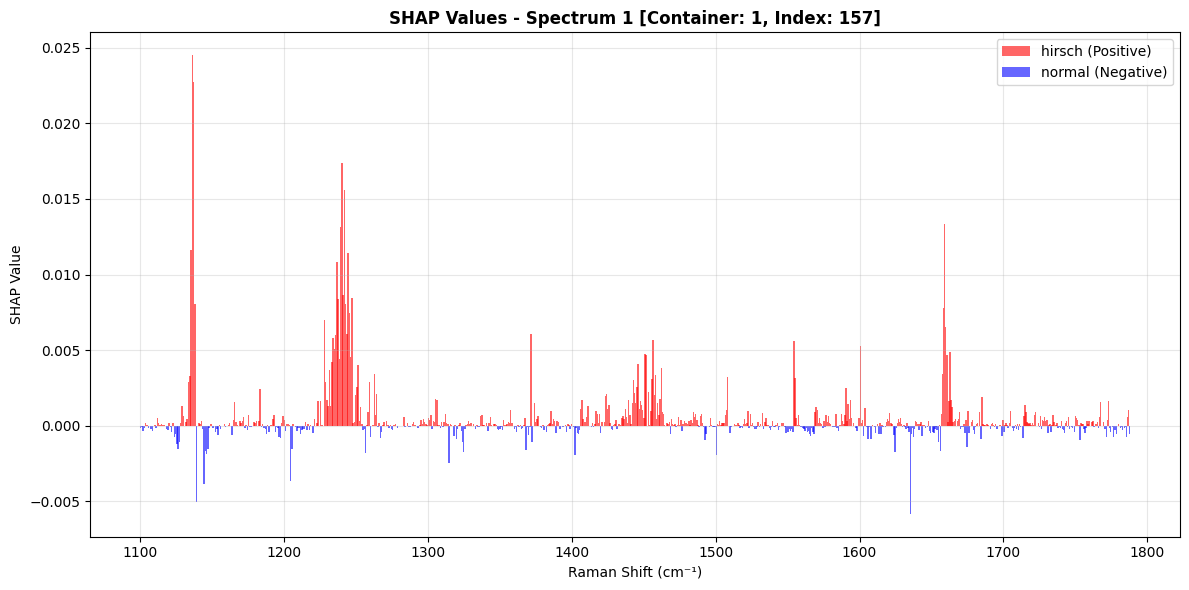

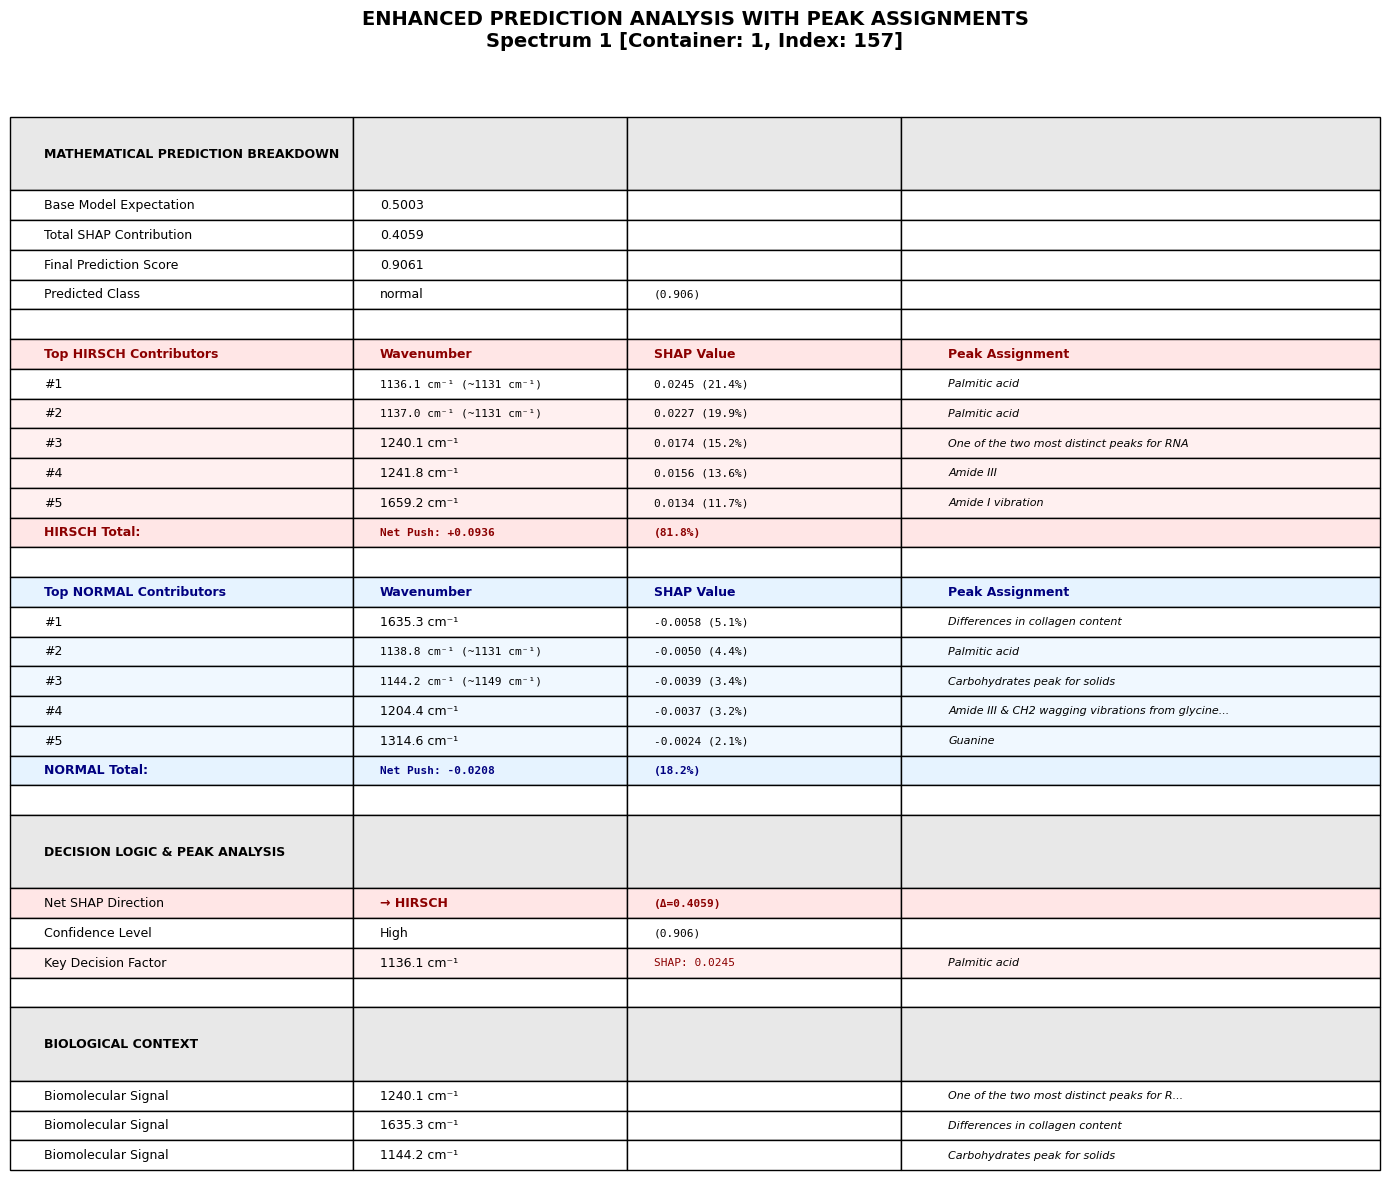

Spectrum 1 Summary [Container: 1, Index: 157]:
  True Label: normal
  Predicted: normal (Confidence: 0.906)
  Correct: Yes
  Top hirsch contributor: 1136.1 cm⁻¹ (SHAP: 0.0245)
  Top normal contributor: 1635.3 cm⁻¹ (SHAP: -0.0058)

Analyzing spectrum 2/4...
Using stored test labels for all samples
Predicting all 1 samples
Predicting 1 test samples with 858 features.
Detected model: RandomForestClassifier, Linear SVC: False
Using stored data: 784 background samples, 1 test samples
Background data reduced to 30 samples
Computing SHAP values for 1 samples with 30 background samples...
Using TreeExplainer for RandomForest model...


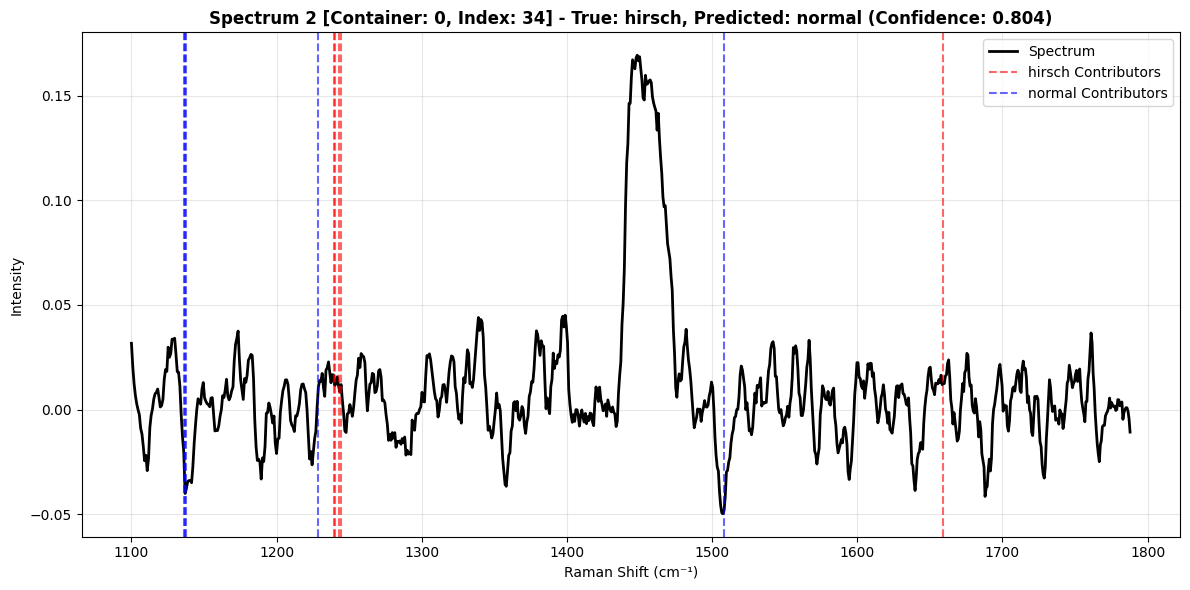

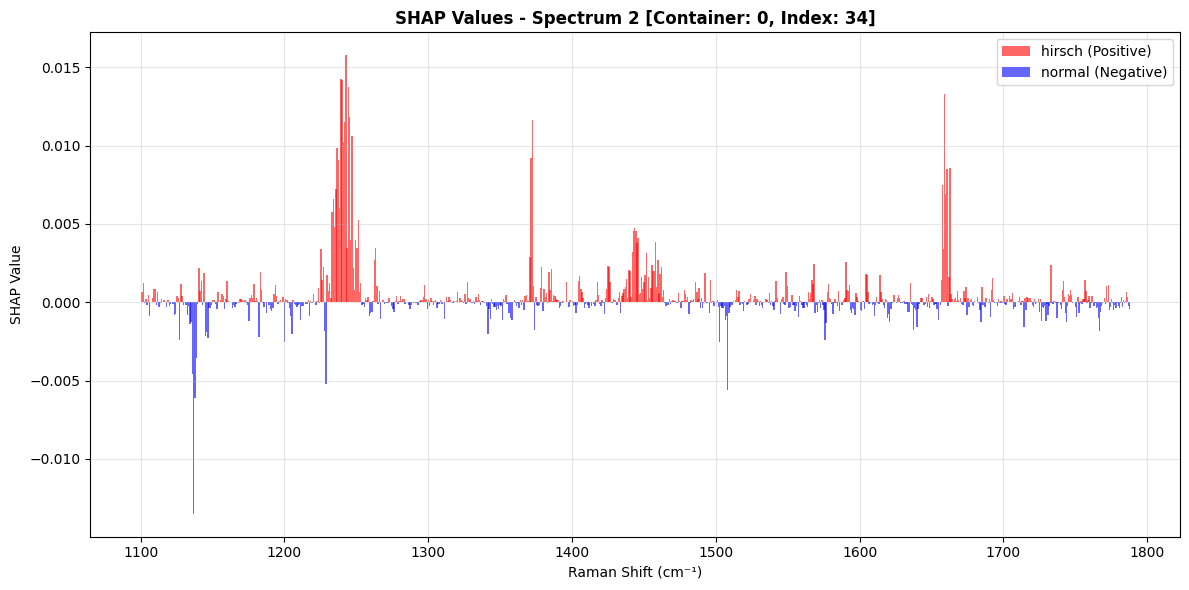

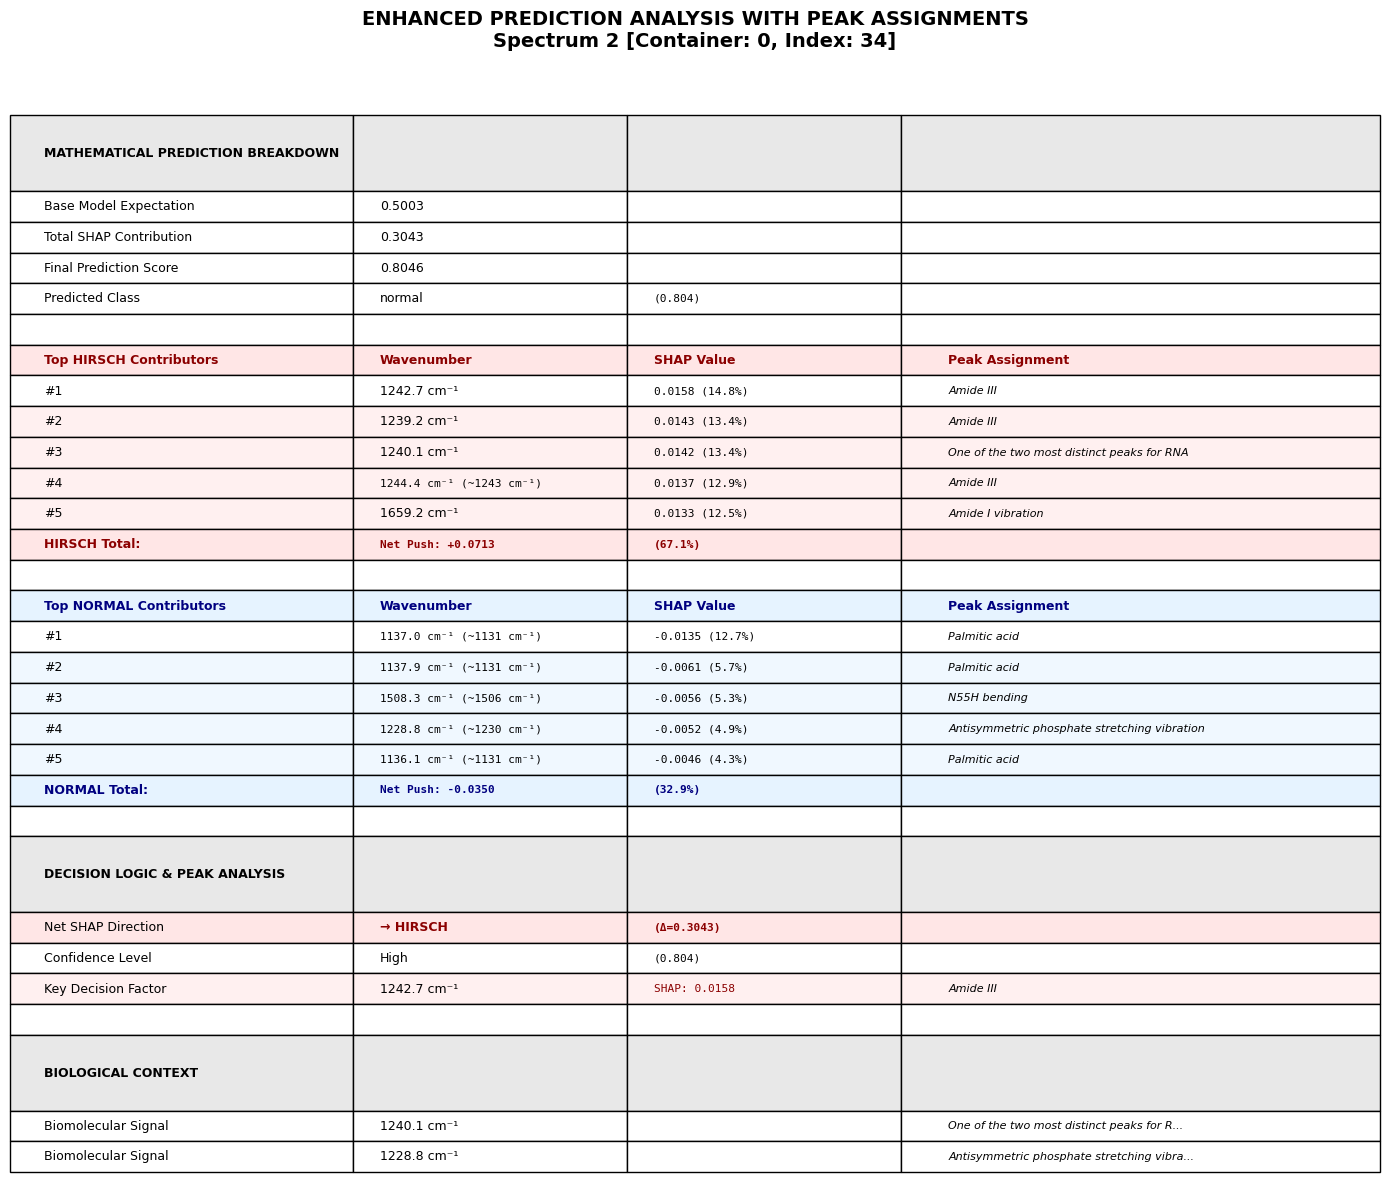

Spectrum 2 Summary [Container: 0, Index: 34]:
  True Label: hirsch
  Predicted: normal (Confidence: 0.804)
  Correct: No
  Top hirsch contributor: 1242.7 cm⁻¹ (SHAP: 0.0158)
  Top normal contributor: 1137.0 cm⁻¹ (SHAP: -0.0135)

Analyzing spectrum 3/4...
Using stored test labels for all samples
Predicting all 1 samples
Predicting 1 test samples with 858 features.
Detected model: RandomForestClassifier, Linear SVC: False
Using stored data: 784 background samples, 1 test samples
Background data reduced to 30 samples
Computing SHAP values for 1 samples with 30 background samples...
Using TreeExplainer for RandomForest model...


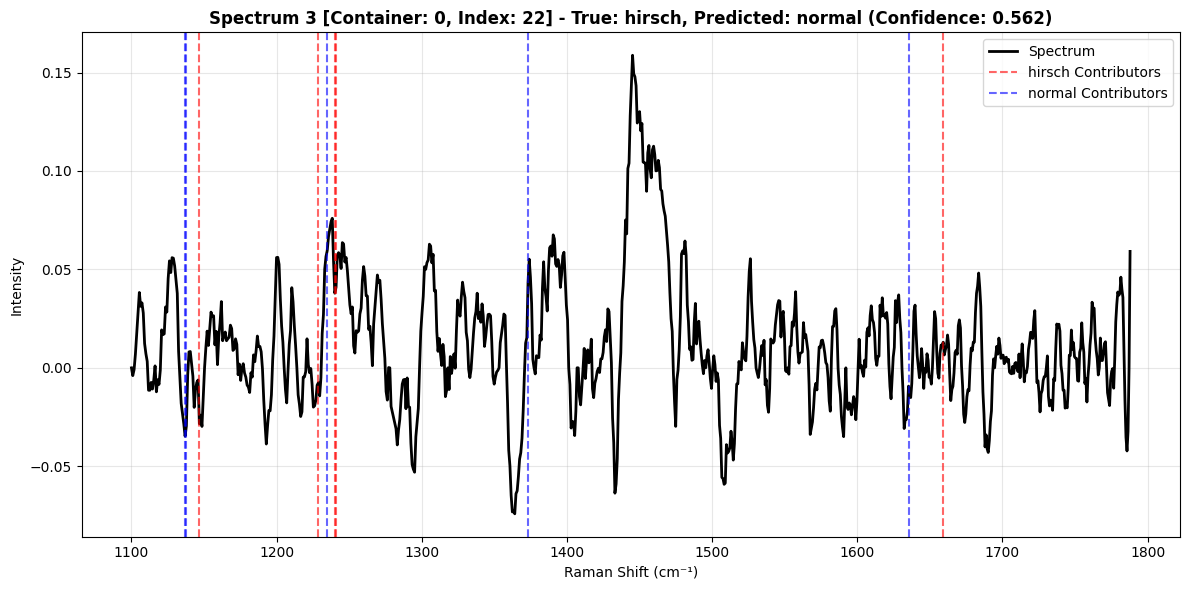

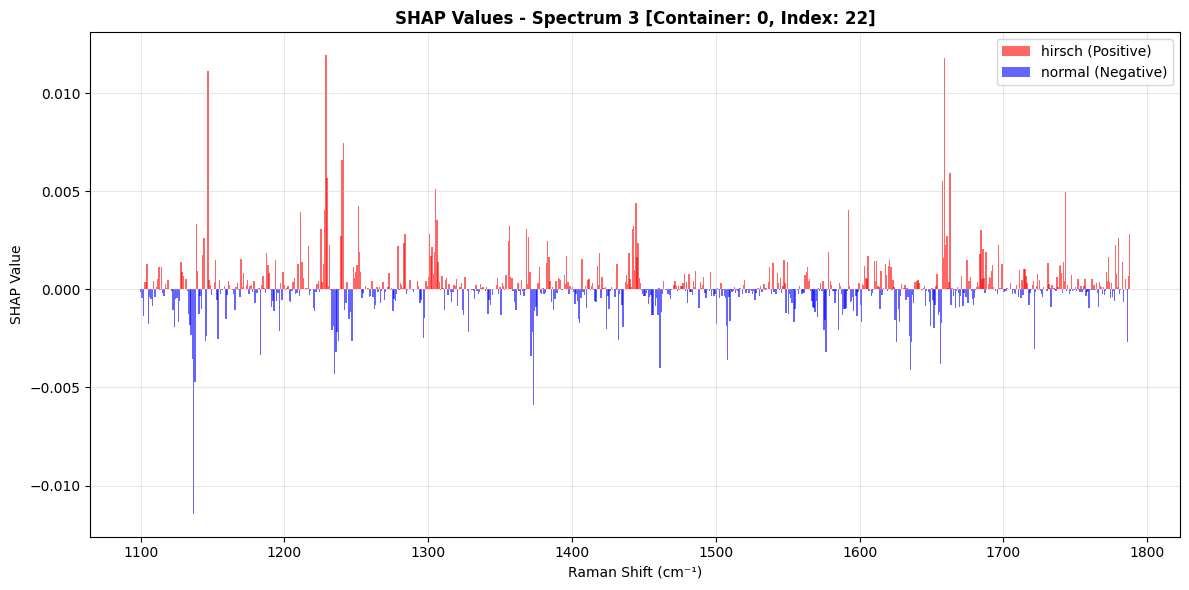

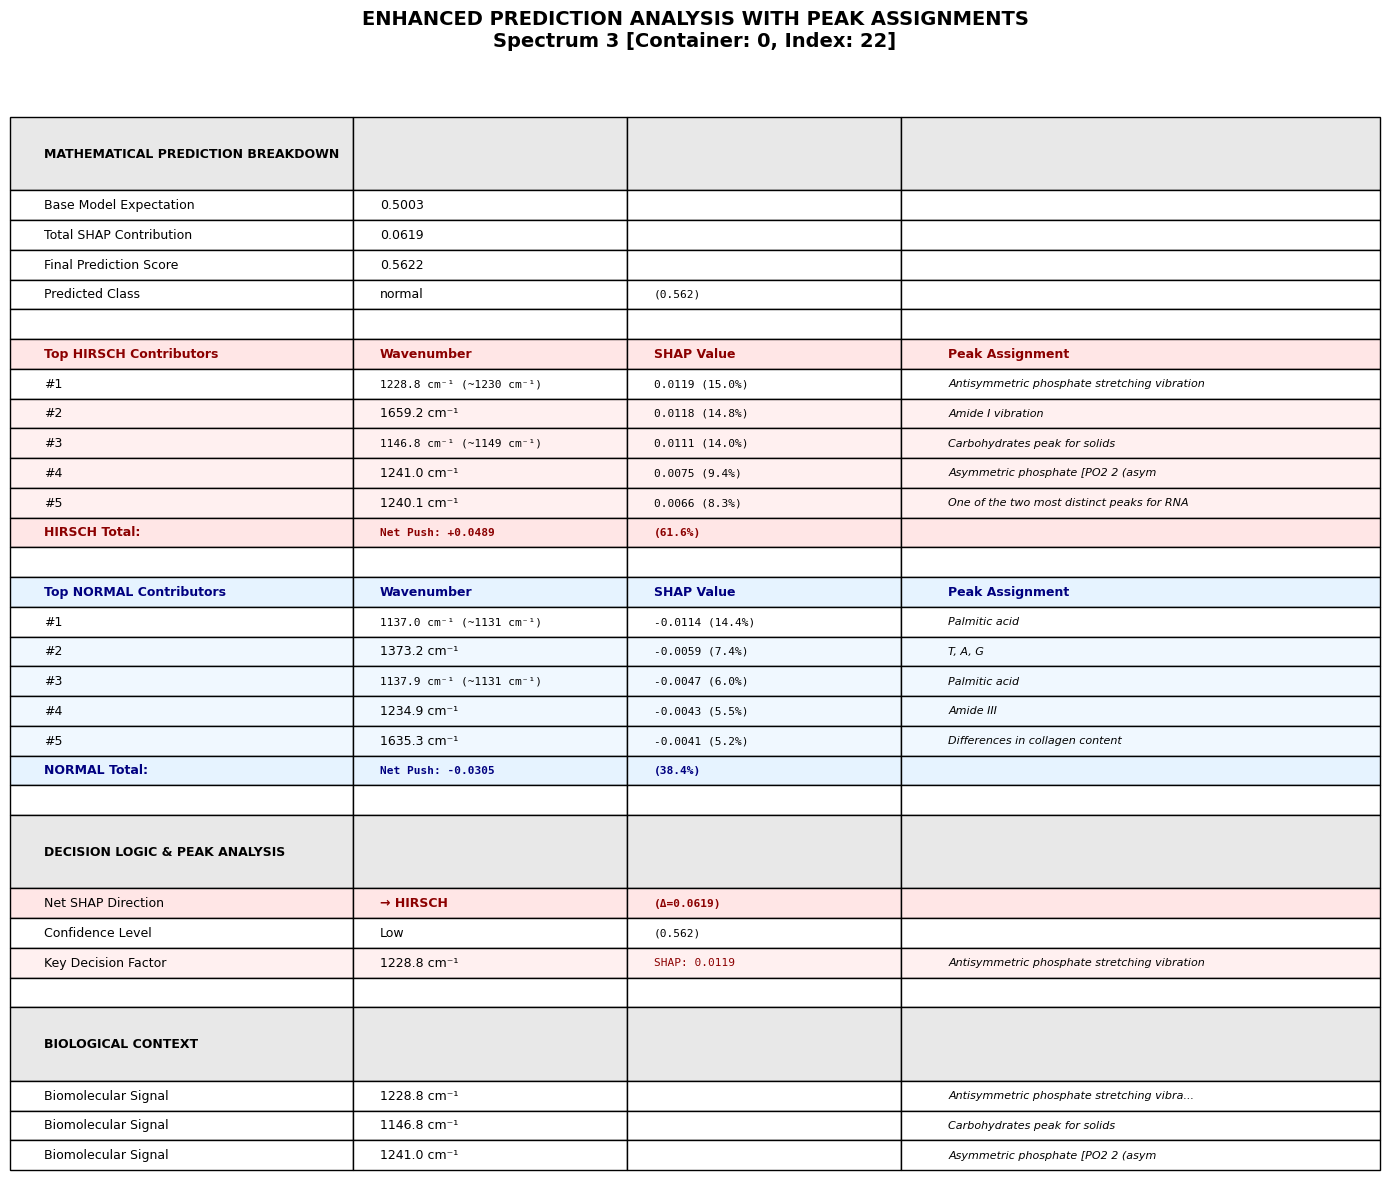

Spectrum 3 Summary [Container: 0, Index: 22]:
  True Label: hirsch
  Predicted: normal (Confidence: 0.562)
  Correct: No
  Top hirsch contributor: 1228.8 cm⁻¹ (SHAP: 0.0119)
  Top normal contributor: 1137.0 cm⁻¹ (SHAP: -0.0114)

Analyzing spectrum 4/4...
Using stored test labels for all samples
Predicting all 1 samples
Predicting 1 test samples with 858 features.
Detected model: RandomForestClassifier, Linear SVC: False
Using stored data: 784 background samples, 1 test samples
Background data reduced to 30 samples
Computing SHAP values for 1 samples with 30 background samples...
Using TreeExplainer for RandomForest model...


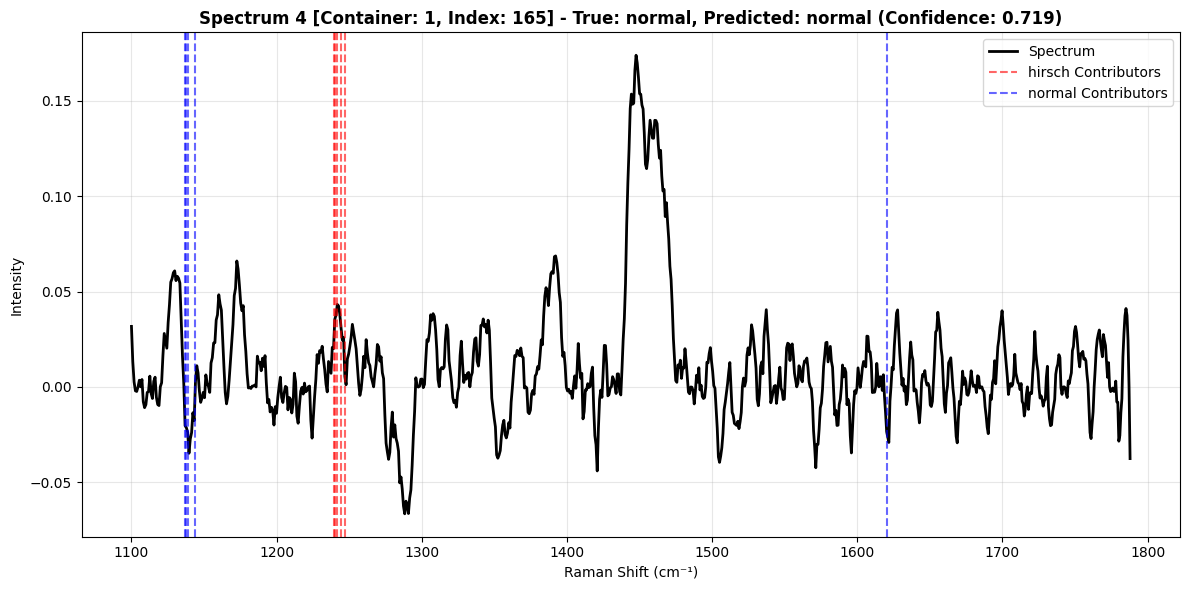

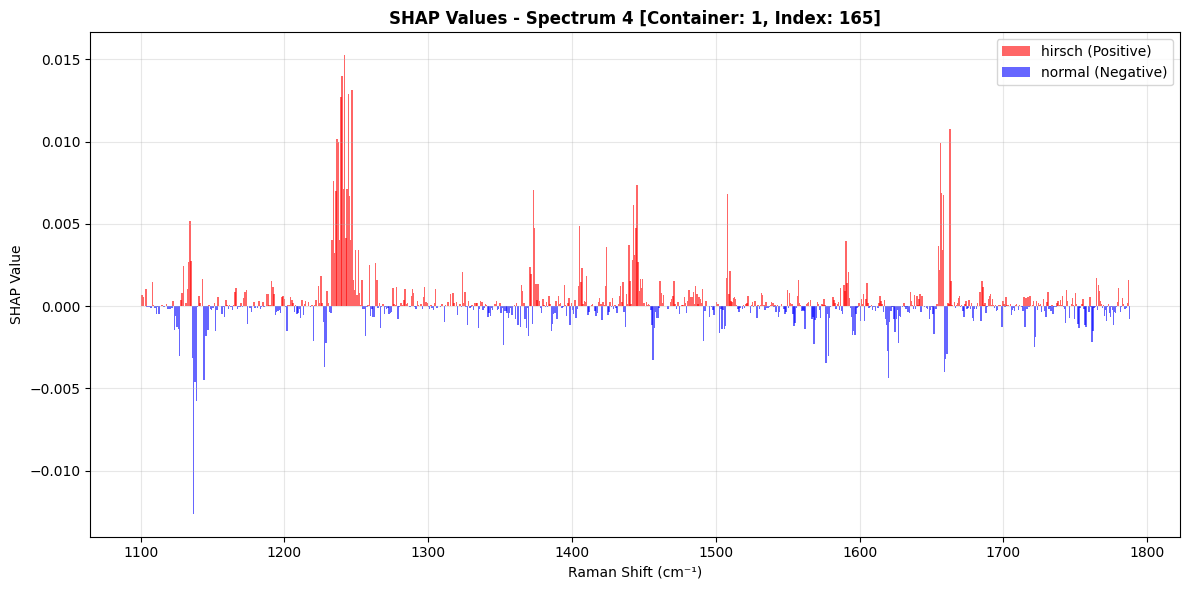

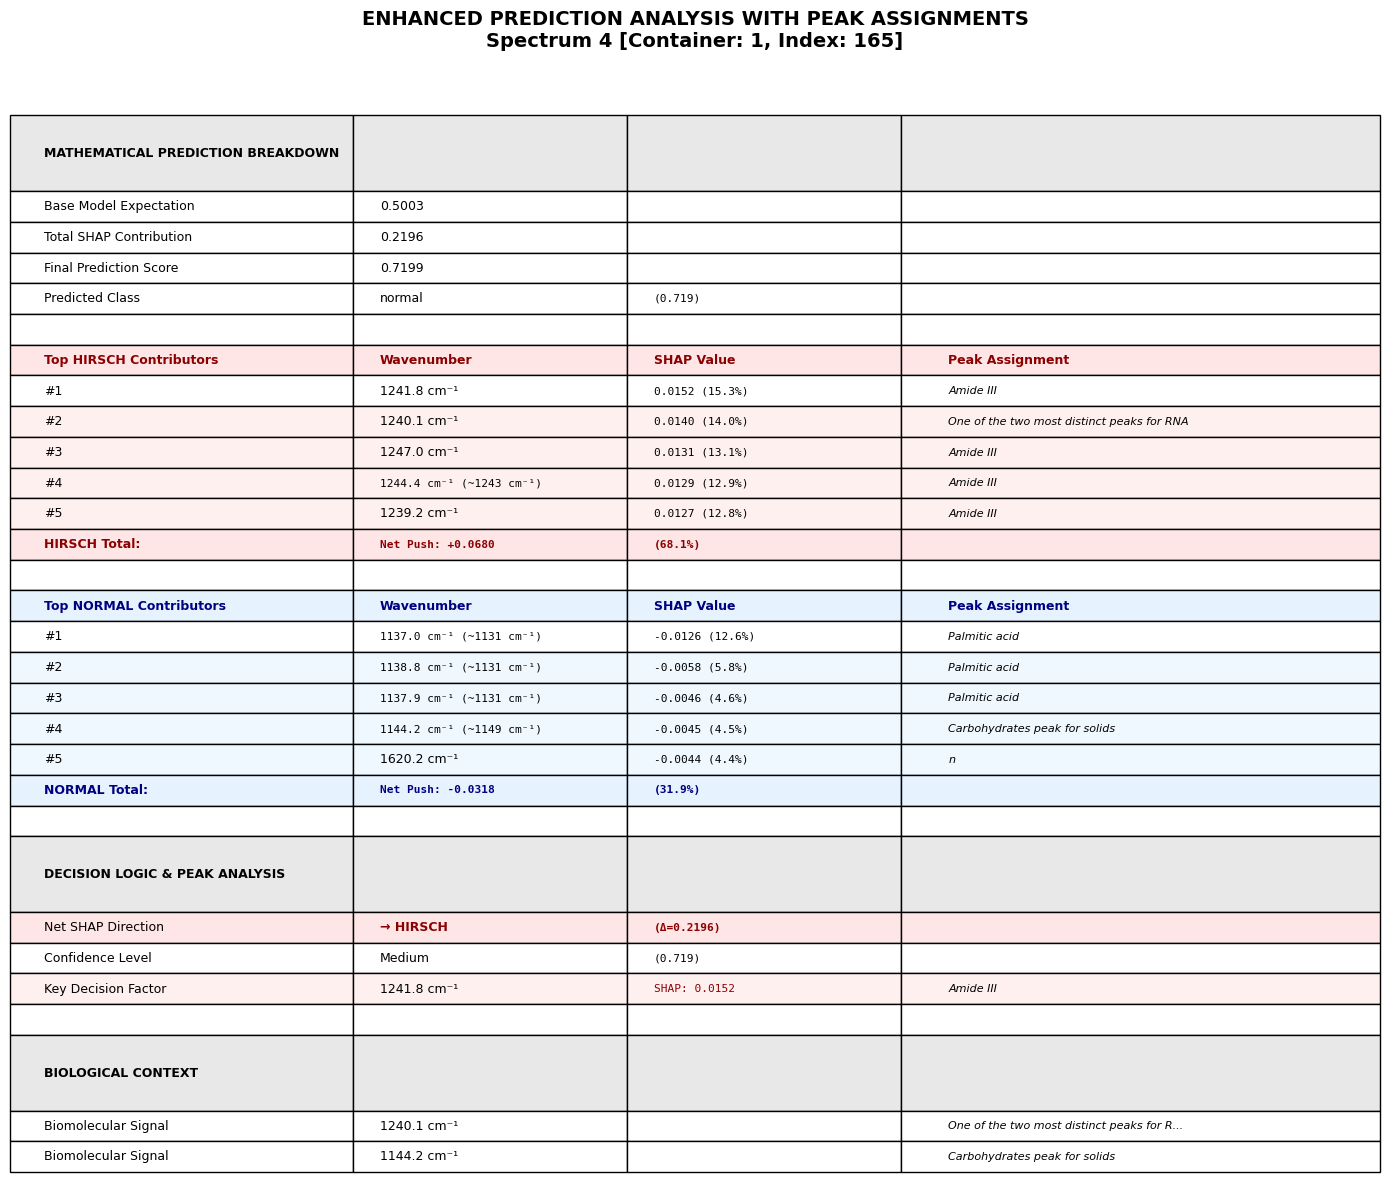

Spectrum 4 Summary [Container: 1, Index: 165]:
  True Label: normal
  Predicted: normal (Confidence: 0.719)
  Correct: Yes
  Top hirsch contributor: 1241.8 cm⁻¹ (SHAP: 0.0152)
  Top normal contributor: 1137.0 cm⁻¹ (SHAP: -0.0126)


In [26]:
sample_indices = []
for key, value in predict_data["prediction_breakdown"].items():
    if len(value) > 0:
        sample_indices.append(value[random.randint(0, len(value))][0])

inspect_spectra = visualizer.inspect_spectra(test_spectra=test_spectra,
                                             true_labels=true_labels,
                                             n_samples=1,
                                             positive_label=labels[1],
                                             negative_label=labels[0],
                                             show_lime_plots=False,
                                             sample_indices=sample_indices,
                                             )